In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Jordy Thielen (jordy.thielen@donders.ru.nl)
"""

import os
from os.path import join
import numpy as np
import pyntbci

#data_dir = os.path.join(os.path.expanduser("~"), "data", "cvep_covert", "experiment")

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
os.chdir(wd)
data_dir = experiment_dir

#npz_data = np.load(file_path)
#subjects = ["VPpdia", "VPpdib"]
subjects = ["VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix", "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]
session = "S001"
tasks = ["covert"]#, "covert"]

event = "refe"
onset_event = True
encoding_length = 0.5
ensemble = False
n_folds = 4
method = "cvep"  # cvep, p300, hybrid

# Loop participants
accuracy = np.zeros((len(subjects), len(tasks), n_folds))
for i_subject, subject in enumerate(subjects):
    print(f"{subject}", end="\t")

    # Loop tasks
    for i_task, task in enumerate(tasks):
        print(f"{task}: ", end="")

        # Load data
        file_dir = os.path.join(derivatives_dir, 'preprocessed', "cvep", f"sub-{subject}")
        fn = os.path.join(file_dir, f"sub-{subject}_task-{task}_cvep.npz") 
        #fn = os.path.join(derivatives_dir, f"sub-{subject}", f"sub-{subject}_task-{task}.npz")
        tmp = np.load(fn)
        fs = int(tmp["fs"])
        X = tmp["X"]  # [:, :, int(fs * 2.1):]
        y = tmp["y"]
        z = tmp["z"]
        V = tmp["V"]
        V = np.tile(V, (1, int(np.ceil(X.shape[2] / V.shape[1]))))[:, :X.shape[2]]

        # Cross-validation
        folds = np.repeat(np.arange(n_folds), int(X.shape[0] / n_folds))
        for i_fold in range(n_folds):
            # Split data to train and test set
            X_trn, y_trn, z_trn = X[folds != i_fold, :, :], y[folds != i_fold], z[folds != i_fold, :, :]
            X_tst, y_tst, z_tst = X[folds == i_fold, :, :], y[folds == i_fold], z[folds == i_fold, :, :]

            # ----------------------------------------------------------------------------------------------------------
            # Train classifier

            # c-VEP event matrix per trial
            E_cvep = pyntbci.utilities.event_matrix(V, event, onset_event)[0]
            E_cvep = E_cvep[y_trn, :, :]

            # P300 event matrix per trial
            E_p300 = np.zeros((E_cvep.shape[0], 2, E_cvep.shape[2]))
            for i_trial in range(y_trn.size):
                for i_target in range(2):
                    idx = 0.250 * fs * np.where(z_trn[i_trial, :, y_trn[i_trial]] == i_target)[0]
                    E_p300[i_trial, i_target, idx.astype("int")] = 1

            # Combine event matrices of c-VEP and P300
            if method == "hybrid":
                E = np.concatenate((E_cvep, E_p300), axis=1)
            elif method == "cvep":
                E = E_cvep
            elif method == "p300":
                E = E_p300
            else:
                raise Exception("Unknown method:", method)

            # Structure matrix
            M = pyntbci.utilities.encoding_matrix(E, int(fs * encoding_length))

            # Perform CCA
            S = X_trn.transpose((0, 2, 1)).reshape((y_trn.size * X.shape[2], X.shape[1]))
            D = M.transpose((0, 2, 1)).reshape((y_trn.size * X.shape[2], M.shape[1]))
            cca = pyntbci.transformers.CCA(n_components=1)
            cca.fit(S, D)

            # ----------------------------------------------------------------------------------------------------------
            # Apply classifier

            # Perform classification per trial because the P300 event structure changes per trial
            yh_tst = np.zeros(y_tst.size)
            for i_trial in range(y_tst.size):

                # c-VEP event matrix
                E_cvep = pyntbci.utilities.event_matrix(V, event, onset_event)[0]

                # P300 event matrix
                E_p300 = np.zeros((E_cvep.shape[0], 2, E_cvep.shape[2]))
                for i_side in range(2):
                    for i_target in range(2):
                        idx = 0.250 * fs * np.where(z_tst[i_trial, :, i_side] == i_target)[0]
                        E_p300[i_side, i_target, idx.astype("int")] = 1

                # Combine event matrices of c-VEP and P300
                if method == "hybrid":
                    E = np.concatenate((E_cvep, E_p300), axis=1)
                elif method == "cvep":
                    E = E_cvep
                elif method == "p300":
                    E = E_p300
                else:
                    raise Exception("Unknown method:", method)

                # Structure matrix
                M = pyntbci.utilities.encoding_matrix(E, int(fs * encoding_length))

                # Apply template matching classifier
                T = cca.transform(None, M)[1][:, 0, :]
                x = cca.transform(X_tst[[i_trial], :, :], None)[0][:, 0, :]
                yh_tst[i_trial] = np.argmax(pyntbci.utilities.correlation(x, T), axis=1)[0]

            # Compute accuracy
            accuracy[i_subject, i_task, i_fold] = np.mean(yh_tst == y_tst)

            mean_acc = np.mean(accuracy[i_subject, i_task, :])
            se_acc = np.std(accuracy[i_subject, i_task, :], ddof=1) / np.sqrt(n_folds)
        print(f"{mean_acc:.3f} ± {se_acc:.3f}", end="\t")
    print()

subject_means = np.mean(accuracy[:, 0, :], axis=1)
overall_mean = np.mean(subject_means)
overall_se = np.std(subject_means, ddof=1) / np.sqrt(len(subjects))
print(f"Average:\tcovert: {overall_mean:.3f} ± {overall_se:.3f}")

np.savez(os.path.join(data_dir, "derivatives", "cvep_rcca_p300.npz"), accuracy=accuracy)


VPpdia	covert: 0.475 ± 0.066	
VPpdib	covert: 0.562 ± 0.043	
VPpdic	covert: 0.675 ± 0.032	
VPpdid	covert: 0.662 ± 0.024	
VPpdie	covert: 0.687 ± 0.062	
VPpdif	covert: 0.575 ± 0.092	
VPpdig	covert: 0.762 ± 0.038	
VPpdih	covert: 0.562 ± 0.031	
VPpdii	covert: 0.550 ± 0.071	
VPpdij	covert: 0.638 ± 0.066	
VPpdik	covert: 0.625 ± 0.052	
VPpdil	covert: 0.400 ± 0.035	
VPpdim	covert: 0.525 ± 0.078	
VPpdin	covert: 0.588 ± 0.038	
VPpdio	covert: 0.637 ± 0.055	
VPpdip	covert: 0.575 ± 0.052	
VPpdiq	covert: 0.700 ± 0.050	
VPpdir	covert: 0.788 ± 0.043	
VPpdis	covert: 0.575 ± 0.052	
VPpdit	covert: 0.588 ± 0.024	
VPpdiu	covert: 0.450 ± 0.046	
VPpdiv	covert: 0.725 ± 0.052	
VPpdiw	covert: 0.637 ± 0.038	
VPpdix	covert: 0.662 ± 0.052	
VPpdiy	covert: 0.500 ± 0.074	
VPpdiz	covert: 0.588 ± 0.077	
VPpdiza	covert: 0.613 ± 0.062	
VPpdizb	covert: 0.525 ± 0.066	
VPpdizc	covert: 0.688 ± 0.047	
Average:	covert: 0.605 ± 0.017


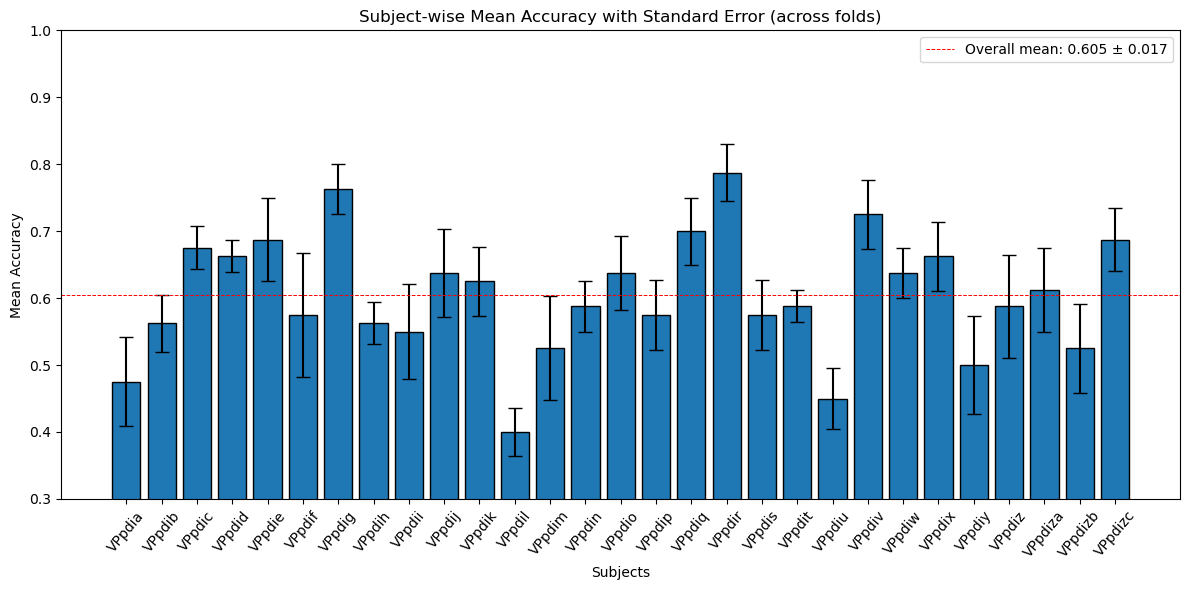

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute subject-level mean accuracy and per-subject SE (across folds)
subject_means = np.mean(accuracy[:, 0, :], axis=1)
subject_se = np.std(accuracy[:, 0, :], ddof=1, axis=1) / np.sqrt(accuracy.shape[2])

# Compute overall mean accuracy and SE (based on subject means only)
overall_mean = np.mean(subject_means)
overall_se = np.std(subject_means, ddof=1) / np.sqrt(len(subject_means))

# Create a bar plot for each subject
fig, ax = plt.subplots(figsize=(12, 6))
subject_indices = np.arange(len(subject_means))
ax.bar(subject_indices, subject_means, yerr=subject_se, capsize=5, color="tab:blue", edgecolor="black")
ax.set_xticks(subject_indices)
# You can use subject IDs or numbers; here we'll assume subjects is a list of strings
subject_labels = subjects
ax.set_ylim(0.3,1)
ax.set_xticklabels(subject_labels, rotation=50)
ax.set_xlabel("Subjects")
ax.set_ylabel("Mean Accuracy")
ax.set_title("Subject-wise Mean Accuracy with Standard Error (across folds)")

# Add overall mean accuracy as a horizontal line with a shaded area for overall SE
ax.axhline(overall_mean, color="red", linestyle="--", linewidth = 0.7, label=f"Overall mean: {overall_mean:.3f} ± {overall_se:.3f}")
ax.axhline(1, color="grey", linestyle="--", linewidth = 0.7)
#ax.fill_between(subject_indices, overall_mean - overall_se, overall_mean + overall_se, color="red", alpha=0.2)

ax.legend()
plt.tight_layout()
plt.show()


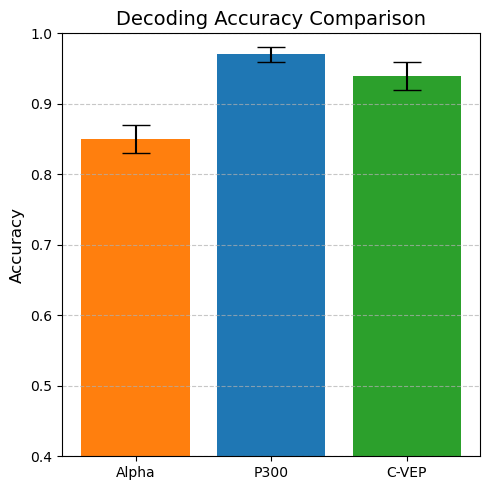

In [3]:
import matplotlib.pyplot as plt

# Data for pipelines
pipelines = ['Alpha', 'P300', 'C-VEP']
accuracies = [0.85, 0.97, 0.94]
standard_errors = [0.02, 0.01, 0.02]  # Converted from decimals (0.02, 0.01) to percentages (2%, 1%)

# Create bar plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(pipelines, accuracies, yerr=standard_errors, capsize=10, color=['tab:orange', 'tab:blue', 'tab:green'])

# Add labels and title
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Decoding Accuracy Comparison', fontsize=14)
ax.set_ylim(0.4, 1)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()
